## 通过神经网络预测房价
在这个项目中，我们希望能够构建神经网络来预测房屋的价格

首先，我们导入一些必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

读取训练集和测试集的数据

In [2]:
train = pd.read_csv('./all/train.csv')
test = pd.read_csv('./all/test.csv')

可以具体看看前面 5 个训练集长什么样子，可以看到，前面都是这个房屋的属性，最后是房屋的价格

In [28]:
train.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,11.870600
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.634603
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,12.206073
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,11.774520
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,11.678440


接着我们可以看看训练集和测试集分别有多少个样本

In [4]:
print('一共有 {} 个训练集样本'.format(train.shape[0]))
print('一共有 {} 个测试集样本'.format(test.shape[0]))

一共有 1460 个训练集样本
一共有 1459 个测试集样本


接着我们开始对数据进行处理，首先我们取出**第二个特征**到**倒数第二个特征**，这些特征作为我们神经网络的输入特征

In [5]:
# 训练集和测试集混合处理，这样好吗
all_features = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                          test.loc[:, 'MSSubClass':'SaleCondition']))

In [6]:
print(all_features.shape)

(2919, 79)


In [12]:
all_features.dtypes[all_features.dtypes != 'object'].index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

接着我们需要进行数据标准化，对于所有的数值特征，我们都会减去均值，除以方差

In [13]:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index # 取出所有的数值特征(名称)

# 减去均值，除以方差
all_features[numeric_feats] = all_features[numeric_feats].apply(lambda x: (x - x.mean()) 
                                                                / (x.std()))

In [14]:
# 对预测的价格取 log
train['SalePrice'] = np.log(train['SalePrice'])
train['SalePrice'].shape

(1460,)

如果你仔细看看上面的特征，你会发现，除了数值特征之外，还有很多非数值特征，这些特征我们没有办法将其转换成数值表示，所以我们通过 pandas 的内置函数将其转换成种类表示

比如 **MSZoning** 有两种可能，一种是 RL，一种是 RM，那么我们就将这个特征变成两个新的特征，RL 和 RM，如果这个数据在 **MSZoning** 上是 RL，那么 RL 取 1，RM 取 0；反之如果这个特征是 RM，那么 RL 取 0，RM 取 1.

| RL | RM |
|-|-|
| 0 | 1 |
| 1 | 0 |

In [26]:
s = pd.Series(list('abca'))
print(s)
print(pd.get_dummies(s))
s1 = ['a', 'b', np.nan]
print(s1)
print(pd.get_dummies(s1))
print(pd.get_dummies(s1, dummy_na=True))
pd.get_dummies(s1, dummy_na=True).shape

0    a
1    b
2    c
3    a
dtype: object
   a  b  c
0  1  0  0
1  0  1  0
2  0  0  1
3  1  0  0
['a', 'b', nan]
   a  b
0  1  0
1  0  1
2  0  0
   a  b  NaN
0  1  0    0
1  0  1    0
2  0  0    1


(3, 3)

In [23]:
# 对离散特征数据进行编码
all_features = pd.get_dummies(all_features, dummy_na=True)

In [24]:
all_features.shape

(2919, 331)

### 所以离散数据编码会使得结果的特征进行扩充

除此之外，我们会发现整个数据中有一些丢失数据，这些丢失数据都是 'NA'，我们没有办法将这些数据输入到网络中，所以需要对这些丢失数据进行赋值，这里我们将数据的均值填入到丢失数据中

In [29]:
all_features = all_features.fillna(all_features.mean())
feat_dim = all_features.shape[1]

In [30]:
print(feat_dim)

331


前面我们已经做好了数据的预处理，下面我们将所有的训练集和验证集都取出成为一个 numpy 的数组

In [31]:
num_train = int(0.9 * train.shape[0]) # 划分训练样本和验证集样本
indices = np.arange(train.shape[0])
np.random.shuffle(indices)  # shuffle 顺序
train_indices = indices[:num_train]
valid_indices = indices[num_train:]

# 提取训练集和验证集的特征
train_features = all_features.iloc[train_indices].values.astype(np.float32)
train_features = torch.from_numpy(train_features)
valid_features = all_features.iloc[valid_indices].values.astype(np.float32)
valid_features = torch.from_numpy(valid_features)
train_valid_features = all_features[:train.shape[0]].values.astype(np.float32)
train_valid_features = torch.from_numpy(train_valid_features)

# 提取训练集和验证集的label
train_labels = train['SalePrice'].values[train_indices, None].astype(np.float32)
train_labels = torch.from_numpy(train_labels)
valid_labels = train['SalePrice'].values[valid_indices, None].astype(np.float32)
valid_labels = torch.from_numpy(valid_labels)
train_valid_labels = train['SalePrice'].values[:, None].astype(np.float32)
train_valid_labels = torch.from_numpy(train_valid_labels)

In [32]:
test_features = all_features[train.shape[0]:].values.astype(np.float32)
test_features = torch.from_numpy(test_features)

下面是构建神经网络的地方，可以构建任意想要的神经网络

In [33]:
def get_model():
    net = nn.Sequential(
        nn.Linear(feat_dim, 1)
    )
    return net

net = get_model()
print(net)

Sequential(
  (0): Linear(in_features=331, out_features=1, bias=True)
)


在评估模型的时候，为了保证大的价格和小的价格对模型都有着近似相同的影响，我们不会直接使用前面定义的均方误差作为最后的评价函数，我们会对预测的价格和真实的价格取 log，然后计算他们之间均方误差的平方根来作为评价指标，这里的指标我们已经在 `utils.py` 中实现了，感兴趣的同学可以去看看。

In [34]:
from utils import train_model, pred

epoch: 10, train rmse: 0.176, valid rmse: 0.221

epoch: 20, train rmse: 0.142, valid rmse: 0.166

epoch: 30, train rmse: 0.125, valid rmse: 0.152

epoch: 40, train rmse: 0.115, valid rmse: 0.144

epoch: 50, train rmse: 0.109, valid rmse: 0.140

epoch: 60, train rmse: 0.106, valid rmse: 0.144

epoch: 70, train rmse: 0.103, valid rmse: 0.145

epoch: 80, train rmse: 0.100, valid rmse: 0.141

epoch: 90, train rmse: 0.099, valid rmse: 0.141

epoch: 100, train rmse: 0.098, valid rmse: 0.143



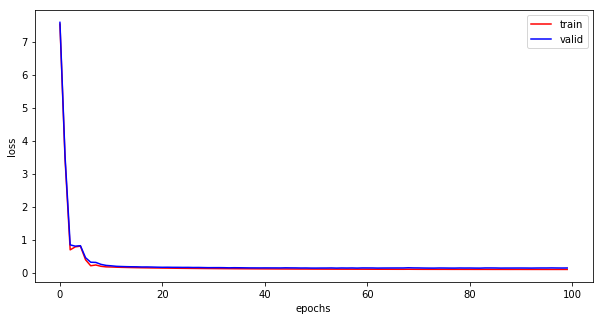

In [38]:
# 可以调整的超参
batch_size = 128
epochs = 100
lr = 0.01
wd = 0
use_gpu = True

net = get_model()
train_model(net, train_features, train_labels, valid_features, valid_labels, epochs, 
            batch_size, lr, wd, use_gpu)

当我们构建好了训练的过程，下面就开始了不断地调参尝试，最后得到一个效果最好的模型

epoch: 10, train rmse: 0.176

epoch: 20, train rmse: 0.136

epoch: 30, train rmse: 0.119

epoch: 40, train rmse: 0.110

epoch: 50, train rmse: 0.105

epoch: 60, train rmse: 0.102

epoch: 70, train rmse: 0.100

epoch: 80, train rmse: 0.099

epoch: 90, train rmse: 0.098

epoch: 100, train rmse: 0.098



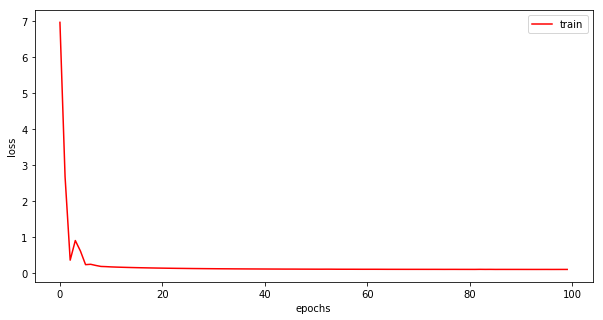

In [39]:
net = get_model()
train_model(net, train_valid_features, train_valid_labels, None, None, epochs, 
            batch_size, lr, wd, use_gpu)

运行下面的代码，可以通过训练好的模型预测 testset 的结果，会在当前目录生成 `submission.csv` 用于提交

In [40]:
pred(net, test, test_features)